# Nutripoints Analysis

In this notebook, we try to understand better how the nutripoints are distributed through our area, how certain nutritional variables can influence it and what is the average distribution the nutrients through the average product of all the areas. 

We have decided to create this variable to facilitate the prediction. Indeed, it is easier to predict one variable than all the nutritional ones. It therefore represents the healthiness of the average product of a specific area by taking into account the different nutrients it is based on.  

We based our computation of the nutripoints on the definition of the national french Nutriscore. The bigger it is, the worst is the average product regarding the level of sugar, saturate, sodium and total energy it has. On the other hand, if it is negative (which is almost impossible), it represents products with higher level of proteins and fibers than "bad nutrients" (salt, sugar, saturate). We adapted the different ranges of the official formula to our database as we have average products and therefore very close data. You can see the detailed function in the file: `utils.py`

Moreover, we realised than when summing the main nutrients (carb, protein, fibre, fat, salt) we didn't reach either the average product's weight or 100. Therefore, we rescaled all our values for a 100g in order to be able to compare between the different areas. 

## Libraries Imports

In [1]:
# Imports
from utils import *
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

## I) Data Imports

We import year_grocery in order to be able to obtain the weight of each nutrients and to compute the total weight for the typical londonian product analysis. 

We also use wellbeing_grocery from the `main` notebook where nutripoints and nutri_label are already computed. However, we select only the columns referring to nutrition variables.

In [2]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())

wellbeing_grocery = pd.read_pickle("data/wellbeing_grocery.pkl")

grocery_analysis = pd.read_pickle("data/grocery_nutripoints.pkl")
display(grocery_analysis.head())
print(grocery_analysis.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,4.0,1
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,5.0,2
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,4.5,1
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,7.5,0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,2.5,3


(510, 12)


##  II) Labelising and adding color

In order to study better the repartition of these nutritpoints, we will create two columns: one with the label corresponding to each cluster and the other with the color. 

We based our label and color assessment on the french Nutriscore scale and rules. 

In [3]:
grocery_analysis.groupby("nutri_class").min()

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
nutri_class,,,,,,,,,,,
0,E05000026,78.434285,29.826159,36.141050,18.245698,69.832483,2.788545,0.849976,176.221977,1.496001,6.5
1,E05000043,72.956706,27.800358,33.119113,18.375916,60.035872,2.774687,0.916022,164.442384,1.534459,3.0
2,E05000032,77.120672,29.169969,34.769148,18.587400,63.329076,2.750710,0.941336,172.879854,1.528599,5.0
3,E05000045,67.111854,26.173163,30.149908,17.661997,52.921834,2.826074,1.195961,147.541243,1.542409,-1.5
4,E05000040,83.698205,33.608620,42.518834,17.596480,74.299701,2.780206,0.715793,183.666368,1.465237,8.5


### A) Nutrilabel

In [4]:
# Converting nutri class (from 0 to 4) into letters (from A to E) called the nutrilabel
def nutri_labels_to_letter(row_list):
    if row_list == 3:
        return "A"
    elif row_list == 1:
        return "B"
    elif row_list == 2:
        return "C"
    elif row_list == 0:
        return "D"
    elif row_list == 4:
        return "E"
    else:
        return ""


grocery_analysis["nutrilabel"] = grocery_analysis.apply(
    lambda row: nutri_labels_to_letter(row["nutri_class"]), axis=1)

As studied in the main, the clusters where not sorted in a particular way. Therefore, we have to pay attention to the range of each cluster to determine their order.

### B) Nutricolor

In [5]:
# Function to set a color to each label
def addcolor(row_list):
    if row_list == "A":
        return "#038141"
    elif row_list == "B":
        return "#85BB2F"
    elif row_list == "C":
        return "#FECC02"
    elif row_list == "D":
        return "#EE8300"
    elif row_list == "E":
        return "#E63F11"
    else:
        return ""


grocery_analysis["color"] = grocery_analysis.apply(
    lambda row: addcolor(row["nutrilabel"]), axis=1)
display(grocery_analysis.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,nutrilabel,color
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,4.0,1,B,#85BB2F
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,5.0,2,C,#FECC02
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,4.5,1,B,#85BB2F
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,7.5,0,D,#EE8300
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,2.5,3,A,#038141


In [6]:
grocery_analysis.to_pickle("plot_data/grocery_nutripoints.pkl")

## III) Data observation

We now try to understand how the nutripoints are distributed. We also want to know the density of each nutrilabel.
Moreover, we thought it was import to visualise the correlation between the nutripoints and each energy as we based our calculations on nutrients weight. The scatter plots is another way to observe the impact of the energy on nurtipoints. 

### A) Nutripoints distribution  

/home/xavi_oliva/Documents/EPFL/ML_course/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


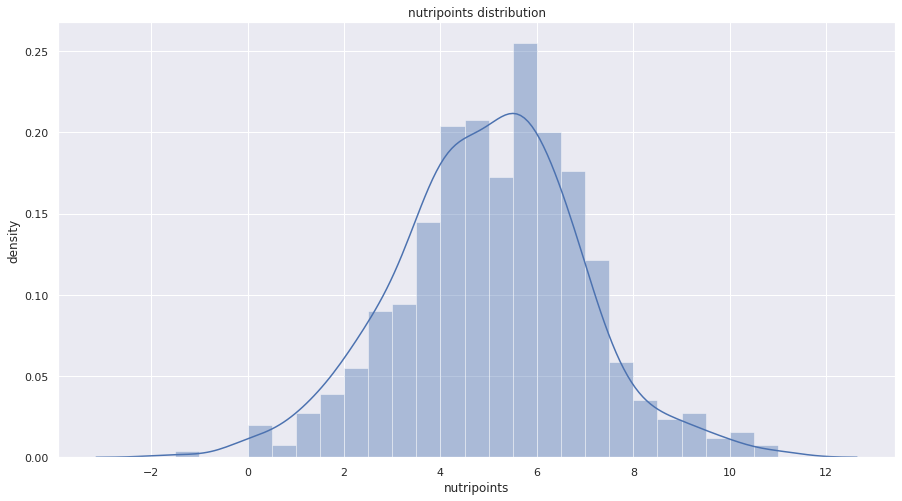

In [7]:
# Explanatory data analysis: distribution of the different variables by counting the number of observations
plt.figure(figsize=(15, 8))

sns.distplot(grocery_analysis["nutripoints"])
plt.xlabel('nutripoints')
plt.ylabel('density')
plt.title('nutripoints distribution')
plt.show();

In [8]:
# checking if nutripoints follow a normal distribution
print(diagnostic.kstest_normal(grocery_analysis.nutripoints, dist='norm'))

(0.07549241912002191, 0.0009999999999998899)


Here, the p_value < 0.05 -> we can reject the null hypothesis that the nutripoints comes from a normal distribution! We could actually observe it on the plot as the curve was not very smooth. 

We can observe that most of the values are between 6 and 12. There is not a lot of variance between our different average products. This explains why we are not able to observe precise clusters. Indeed, we force a bit the separation of the areas in different clusters. 

### B) Nutrilabels distribution 

In order to know, which class has the more area, we plot the nutrilabel distribution. Indeed, it could help later to know if wellbeing variables play a role in taht distribution.

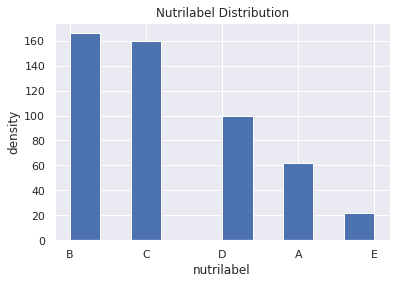

In [9]:
## REVOIR: coloré et mettre du plus petit au plus grand ##
# Plot of the nutrilabel density distribution
plt.figure(figsize=(6, 4))

plt.hist(x=grocery_analysis["nutrilabel"])

plt.xlabel('nutrilabel')
plt.ylabel('density')
plt.title('Nutrilabel Distribution')

plt.show();

The boundary labels are the ones with fewer area. Indeed, most area aggregated and spread between B, C and D. D is the one with the most areas. It is actually quite bad because it means that most areas have unhealthy average product with mainly salt, sugar and/ or fat. If we sum A and B on  one hand and C, D and E on the other side, we can observe that the second sum is higher than A+B. Therefore, most of the average products are in the less healthy class. However, we should not forget our nutripoints distribution where we could observe that there was no big variance between the nutripoints. Therefore, the biundaries between each label are not very precise and the difference between labels is actually very small.

#### Merging to have the Index Score

We add to our original database `wellbeing_nutripoints a column with the Total Wellbeing Score per area.

In [10]:
wellbeing_nutripoints = pd.merge(left=grocery_analysis, right=wellbeing_grocery[['area_id', 'Index Score 2013']],
                                 on="area_id")
wellbeing_nutripoints.to_pickle("plot_data/plot_wellbeing_nutripoints.pkl")
display(wellbeing_nutripoints.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,nutrilabel,color,Index Score 2013
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,4.5,1,B,#85BB2F,4.798106
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,7.5,0,D,#EE8300,0.440499
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,2.5,3,A,#038141,4.269507
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,3.0,1,B,#85BB2F,-2.659193
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,5.5,2,C,#FECC02,-0.489500


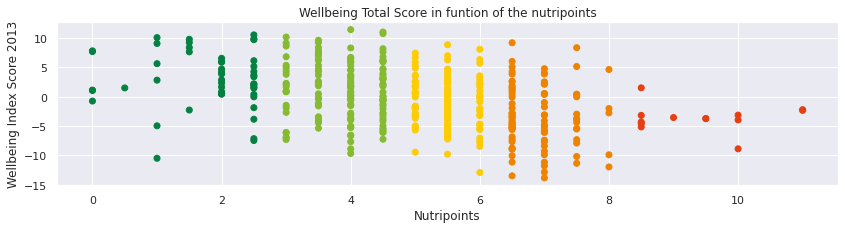

In [11]:
# Plotting the Wellbeing Total Score in function of the nutripoints
plt.figure(figsize=(14, 3))

plt.scatter(wellbeing_nutripoints["nutripoints"],
            wellbeing_nutripoints["Index Score 2013"], c=wellbeing_nutripoints["color"])

plt.xlabel("Nutripoints")
plt.ylabel("Wellbeing Index Score 2013")
plt.title("Wellbeing Total Score in funtion of the nutripoints")
plt.show()

From the above plot, we can visualise better the repartition of the nutrilabels. However, we cannot observe distinct clusters. Indeed, the nutripoint is a continuous variable.

This plot confirms that nutrition is not well correlated to wellbeing. Indeed, wellbeing index score is not decreasing with the nutripoints. Some points in B have a very low Index Score while a point in E has the highest Index Score. In each nutrilabel, we have all sort of Index Score. Therefore, we cannot make conclusions on the impact of wellbeing on nutritional class.

With the merging, we lost our outliers points from A label because we did not have their wellbeing value. 

### C) Nutrients energy and nutripoints correlation and influence

As we have seen it is difficult to understand the effect of wellbeing on nutrition. We however want to observe the correlation between the nutrient energy and the nutripoints as each nutrient play a role in the computation of this variable.

In [12]:
# Computing the correlation between the different variables from the dataset according to the spearman method
correlation = grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
energy_fat,1.000000,0.823451,0.608459,-0.165126,0.585389,-0.029370,-0.365324,0.785848,-0.624390,0.704211,-0.212876
energy_saturate,0.823451,1.000000,0.486850,-0.225230,0.378615,-0.047231,-0.221464,0.553098,-0.465406,0.589331,-0.203060
energy_sugar,0.608459,0.486850,1.000000,-0.539847,0.855277,-0.270308,-0.451466,0.812268,-0.808285,0.611397,-0.204861
energy_protein,-0.165126,-0.225230,-0.539847,1.000000,-0.346762,0.366865,0.325737,-0.212630,0.567731,-0.206381,-0.041434
energy_carb,0.585389,0.378615,0.855277,-0.346762,1.000000,-0.302417,-0.598661,0.943590,-0.875802,0.755076,-0.242793
energy_fibre,-0.029370,-0.047231,-0.270308,0.366865,-0.302417,1.000000,0.181677,-0.196165,0.380603,-0.462778,0.115189
energy_alcohol,-0.365324,-0.221464,-0.451466,0.325737,-0.598661,0.181677,1.000000,-0.530316,0.804910,-0.448616,0.108554
energy_tot,0.785848,0.553098,0.812268,-0.212630,0.943590,-0.196165,-0.530316,1.000000,-0.821297,0.818251,-0.266710
h_nutrients_calories,-0.624390,-0.465406,-0.808285,0.567731,-0.875802,0.380603,0.804910,-0.821297,1.000000,-0.718501,0.204359
nutripoints,0.704211,0.589331,0.611397,-0.206381,0.755076,-0.462778,-0.448616,0.818251,-0.718501,1.000000,-0.298368


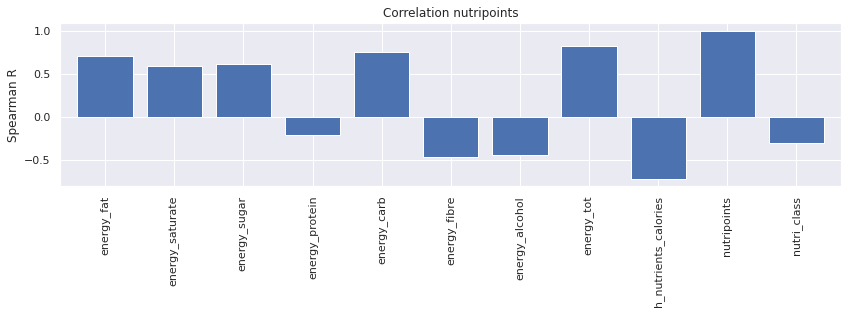

In [13]:
# Computing and plotting the correlation between the different nutrients and the nutripoints
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation nutripoints")
plt.show()

Energy_saturate is the most correlated to nutripoints with 0.59. It is followed by fat (as saturate is comprised in fat) and sugar. We see that what we called the C points in our nutripoints computation corresponding the "bad" points have more weight than the good ones. Indeed, those values are higher. Indeed, there is always more fat and carbs than there is protein and fibre. 

Furthermore, we can see that entropy is negatively correlated with nutripoints. Therefore, a average product with equal proprotion of each nutrient does not rhyme with a good nutripoint. This is explained by the fact that nutripoints value fibre and protein and on the contrary when there is too much saturate, sugar or salt, it is badly classified.

Text(0.5, 0.98, 'Scatter plots of the different areas for food-related predictor pairs')

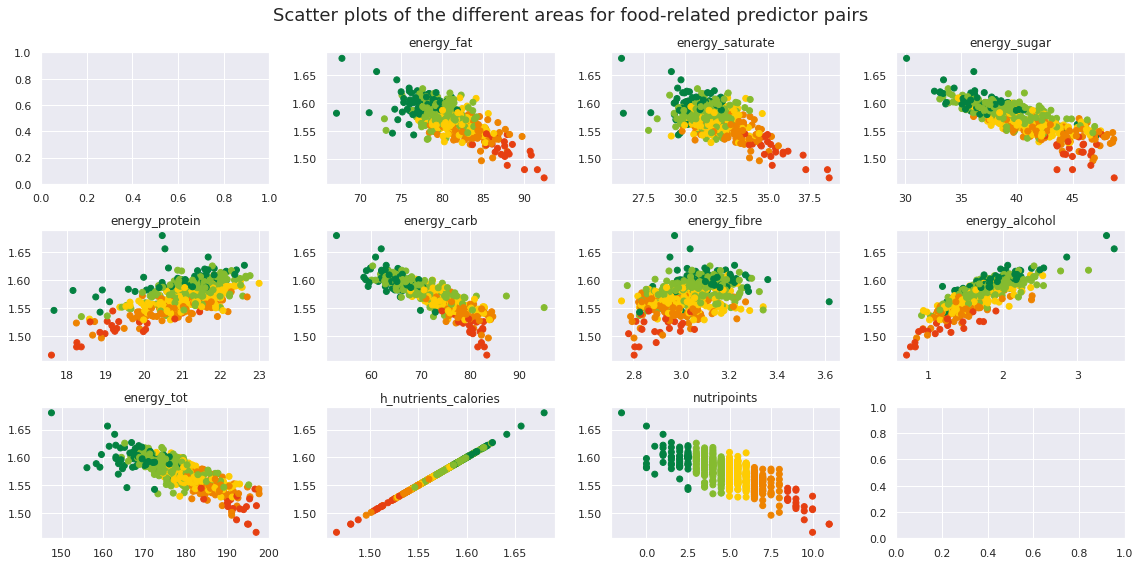

In [14]:
# Representation of ward areas according to their values for food-related predictor pairs
# Colors are set according to the nutrilabel of the area

fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharey=False)

for i in range(1, 11):
    sbplt = ax[int(i/4), i % 4]
    sbplt.scatter(
        grocery_analysis.iloc[:, i], grocery_analysis["h_nutrients_calories"], c=grocery_analysis["color"])
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle(
    'Scatter plots of the different areas for food-related predictor pairs', fontsize=18)

When representing entropy in function of each nutrient or nutripoints, we can observe their impact on the entropy.

For instance, a low energy product wiuld have a higher entropy than one with high energy. Indeed, high energy often means too much fat or carb which are very caloric taking place for other nutrients. It seems that most of A and B have lower total energy and therefore higher entropy. This decreasing trend can be observed for sugar and carb too but it is less distinct for fat and saturate. 

Moreover, incerasing trend is more difficult to assess for protein and fibre. They are more aggregated in a corner of the graph.

When observing the nutripoints figure, we actually observe that indeed, the lowest entropy are part of D and E classes. However, it seems that their entropy mean would be approximately the same between the different labels.

## Typical Londoner product analysis 

We want to analyse the repartition of the different nutrients in an average product. 

We compute therefore the average total_weight and avearge weight of each nutrients. We then represent them in a pie chart to visualize better. 

We will try to compare this repartition with the WHO recommendation. 

In [15]:
# Main classes of nutrients
NUTRIENTS = ["fibre", "protein", "carb", "fat", "salt"]

In [16]:
# Creating a dataframe with all the nutrient's weight from year_grocery
weight = year_grocery[["area_id"]+NUTRIENTS].copy()

In [17]:
# Computing the total nutrient's weight
weight["weight_total"] = weight[NUTRIENTS].sum(axis=1)
display(weight.head())

,area_id,fibre,protein,carb,fat,salt,weight_total
0,E05000026,1.564721,4.977560,19.381951,9.488797,0.583240,35.996270
1,E05000027,1.581960,5.211694,18.950348,9.733634,0.568184,36.045821
2,E05000028,1.572323,5.192412,19.662048,9.216310,0.610536,36.253629
3,E05000029,1.550344,4.718184,20.084734,9.700137,0.533180,36.586579
4,E05000030,1.607947,5.307003,19.581403,9.381808,0.566784,36.444945


In [18]:
# Computing the features for typical londonner product based on the average weight of each nutrients
weight_mean = weight.mean(axis=0)
display(weight_mean)

fibre            1.627422
protein          5.267340
carb            18.256906
fat              9.028830
salt             0.577493
weight_total    34.757991
dtype: float64

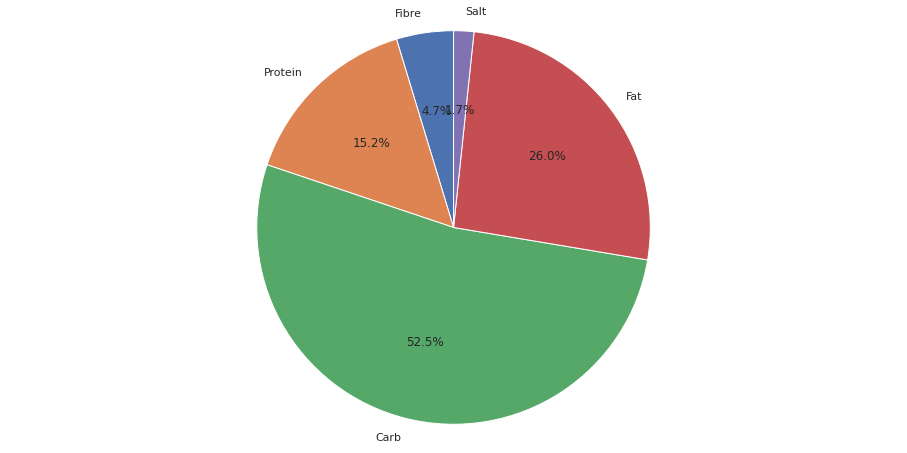

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
nutrients_labels = ["Fibre", "Protein", "Carb", "Fat", "Salt"]
fig1, ax1 = plt.subplots(figsize=(16, 8))
ax1.pie(weight_mean[0:5], labels=nutrients_labels,
        autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

This pie charty visually shows the proportion of each nutrient in the average londonian product. It will be compared to recommendation for a healthy diet.   

Carbs: 45 to 65%  
Fat: 20 to 35%  
Protein:  10 to 35%   
Fibre: 14%

#https://healthyeating.sfgate.com/recommended-fats-carbohydrates-proteins-sodium-4478.html#

In [20]:
# Merge year_grocery and weight
weight_label = pd.merge(left=weight, right=grocery_analysis[[
                        "area_id", "nutrilabel"]], left_on="area_id", right_on="area_id")
display(weight_label[(weight_label["nutrilabel"] == "A")
                     | (weight_label["nutrilabel"] == "B")].head(50))

,area_id,fibre,protein,carb,fat,salt,weight_total,nutrilabel
10,E05000043,1.643920,5.436584,17.968808,8.965348,0.603542,34.618202,B
12,E05000045,1.628036,5.018297,16.363164,8.547769,0.543920,32.101188,A
13,E05000046,1.543967,5.116965,17.491387,8.743245,0.545433,33.440997,B
17,E05000050,1.599209,4.415499,17.485833,8.215241,0.481553,32.197334,A
18,E05000051,1.668802,5.046031,16.060957,8.452983,0.563312,31.792086,A
19,E05000052,1.733044,4.943774,15.759499,8.581579,0.541838,31.559734,A
20,E05000053,1.641468,4.539366,16.591355,7.456873,0.491664,30.720726,A
21,E05000054,1.910616,4.777717,18.883024,8.440627,0.523606,34.535591,A
22,E05000055,1.615483,4.730159,16.188600,7.899728,0.497278,30.931248,A
23,E05000056,1.647188,5.465033,17.700409,8.909073,0.603187,34.324891,B


In [21]:
weight_label = weight_label.groupby("nutrilabel").mean()
display(weight_label)

,fibre,protein,carb,fat,salt,weight_total
nutrilabel,,,,,,
A,1.639067,5.248647,16.205427,8.559657,0.545976,32.198773
B,1.625563,5.321346,17.453245,8.853137,0.572121,33.825411
C,1.609790,5.310581,18.377801,9.011153,0.595461,34.904785
D,1.592894,5.228689,19.267845,9.216409,0.594005,35.899841
E,1.576119,4.858590,20.101771,9.761713,0.557156,36.855349


In [22]:
#fig, ax = plt.subplots(1, 5, figsize=(16, 16))

# for i in range(len(weight_label)):
#  sbplt = ax[i]
# sbplt.pie(weight_label.iloc[i,0:5], labels=nutrients_labels, autopct='%1.1f%%', startangle=90)
# sbplt.axis('equal')
# sbplt.set_title(weight_label.index[i])
# fig.tight_layout()
# fig.subplots_adjust(top=0.5)

#fig.suptitle('Pie plot for each nutrilabel', fontsize=18)